# 🧠 Customer Segmentation with RFM & Clustering  

This notebook is the second part of the Online Retail (UCI) project.

Its goal is to:
- engineer RFM features (Recency, Frequency, Monetary)
- standardize and transform these features
- apply clustering to segment customers
- visualize and interpret the resulting customer groups

The cleaned dataset used here comes from Notebook 01.

# 📚 1 — Libraries

In [51]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

np.random.seed(1)

# 📁 2 — Load cleaned dataset

In [52]:
data = pd.read_csv("data_cleaned.csv")

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['CustomerID'] = data['CustomerID'].astype('object')
data['InvoiceNo'] = data['InvoiceNo'].astype('object')

data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34


# 🧮 3 — RFM Feature Engineering

## 3.1 - Compute Recency, Frequency, Monetary (RFM)

In [53]:
limit_date = data['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = data.groupby('CustomerID', as_index=False).agg({
    'InvoiceDate': lambda x: (limit_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12347,2,7,4310.00
1,12348,75,4,1437.24
2,12349,19,1,1457.55
3,12350,310,1,294.40
4,12352,36,6,1265.41


## 3.2 - Visualize distributions

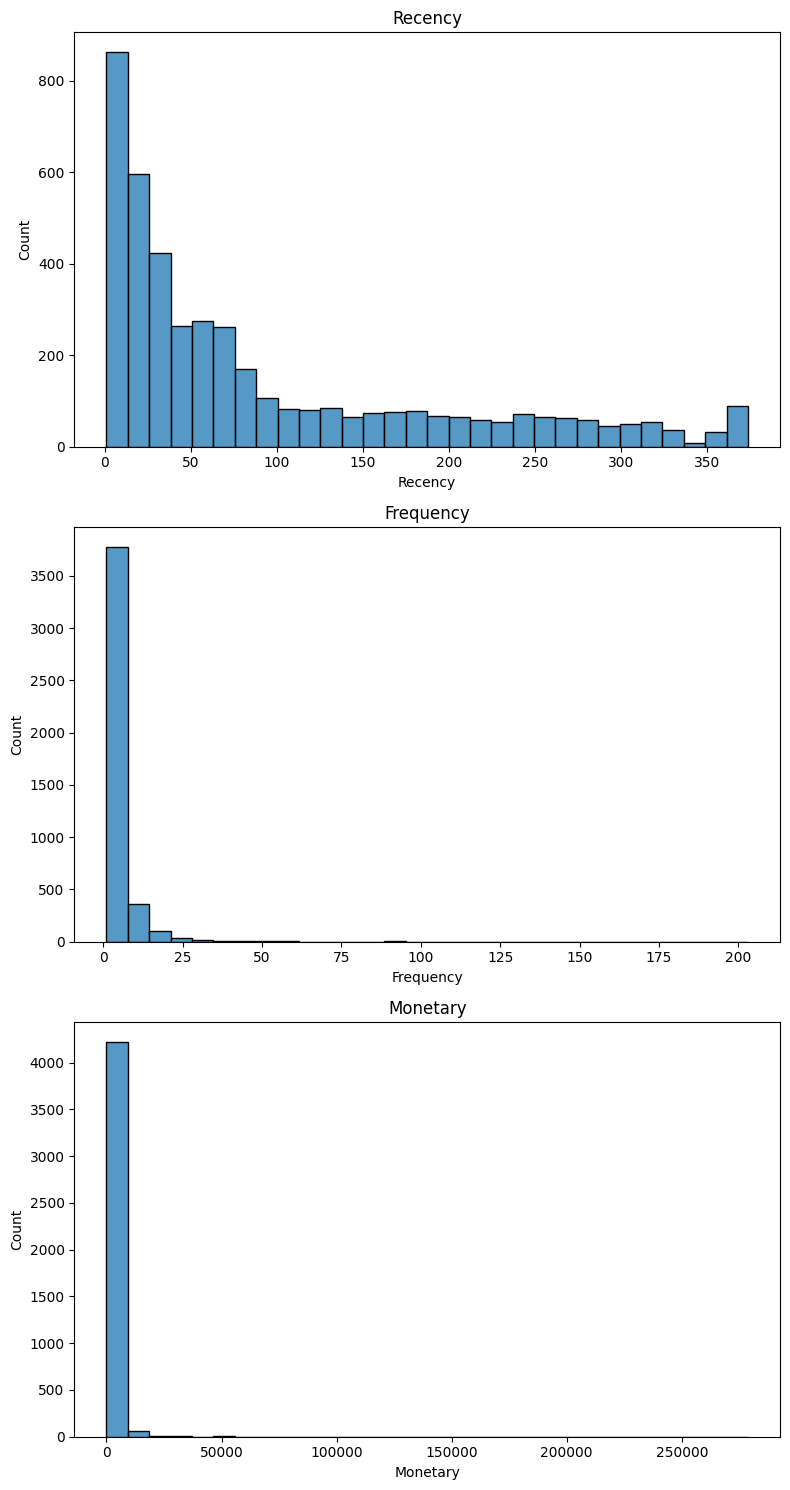

In [54]:
fig, axes = plt.subplots(3, 1, figsize=(8, 15))

sns.histplot(rfm['Recency'], bins=30, ax=axes[0])
axes[0].set_title("Recency")

sns.histplot(rfm['Frequency'], bins=30, ax=axes[1])
axes[1].set_title("Frequency")

sns.histplot(rfm['Monetary'], bins=30, ax=axes[2])
axes[2].set_title("Monetary")

plt.tight_layout()
plt.show()

## 3.3 - Log transformation

In [55]:
rfm['Recency_log'] = np.log1p(rfm['Recency'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log
0,12347,2,7,4310.00,1.098612,2.079442,8.368925
1,12348,75,4,1437.24,4.330733,1.609438,7.271175
2,12349,19,1,1457.55,2.995732,0.693147,7.285198
3,12350,310,1,294.40,5.739793,0.693147,5.688330
4,12352,36,6,1265.41,3.610918,1.945910,7.143941


## 3.4 - Standardization

In [56]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency_log', 'Frequency_log', 'Monetary_log']])

rfm_scaled_df = pd.DataFrame(
    rfm_scaled,
    columns=['Recency_scaled','Frequency_scaled','Monetary_scaled']
)
rfm_scaled_df.head()

,Recency_scaled,Frequency_scaled,Monetary_scaled
0,-2.038083,1.089465,1.462046
1,0.372186,0.398067,0.580928
2,-0.623356,-0.949842,0.592183
3,1.422955,-0.949842,-0.689556
4,-0.164597,0.893034,0.478803


# 🎯 4 — Customer Clustering

## 4.1 - Determine optimal number of clusters

In [57]:
def search_best_cluster(X,
                        min_k=2,
                        max_k=12,
                        compute_silhouette=True,
                        show_elbow=True,
                        show_silhouette=False,
                        sample_size=1000):
    """
    Search for the optimal number of clusters using:
    - Inertia (Elbow method)
    - Silhouette score (optional, sampled for speed)
    """

    inertia = []
    silhouette_scores = []

    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=1)
        labels = kmeans.fit_predict(X)

        inertia.append(kmeans.inertia_)

        if compute_silhouette:
            score = silhouette_score(X, labels, sample_size=sample_size)
            silhouette_scores.append(score)

    # Plot elbow
    if show_elbow:
        plt.figure(figsize=(6,4))
        plt.plot(range(min_k, max_k + 1), inertia, marker='o')
        plt.title("Elbow Method")
        plt.xlabel("k")
        plt.ylabel("Inertia")
        plt.show()

    # Plot silhouette
    if compute_silhouette and show_silhouette:
        plt.figure(figsize=(6,4))
        plt.plot(range(min_k, max_k + 1), silhouette_scores, marker='o')
        plt.title("Silhouette Score")
        plt.xlabel("k")
        plt.ylabel("Silhouette")
        plt.show()

    return inertia, silhouette_scores


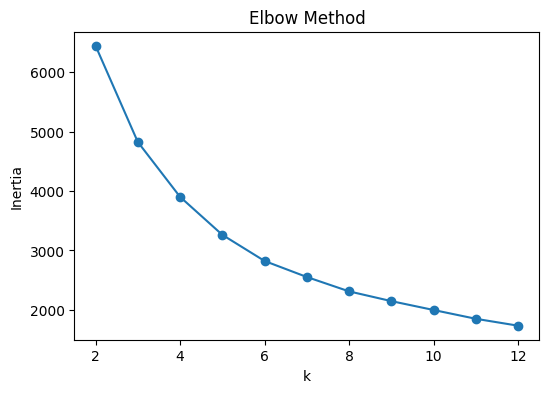

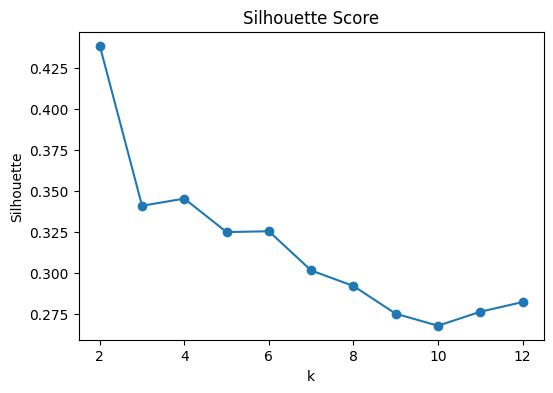

In [58]:
inertia, sil = search_best_cluster(
    rfm_scaled,
    min_k=2,
    max_k=12,
    compute_silhouette=True,
    show_elbow=True,
    show_silhouette=True
)

### 🔍 Interpretation :
Based on the elbow and silhouette curves, k=5 provides the best balance between compactness and separation.

## 4.2 - Fit final KMeans model

In [59]:
kmeans = KMeans(n_clusters=5, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("Number of customers in each cluster:")
rfm['Cluster'].value_counts().sort_index()

Number of customers in each cluster:


,count
Cluster,
0,880
1,943
2,1017
3,1144
4,335


## 4.3 - PCA for visualization

In [60]:
pca = PCA()
pca.fit(rfm_scaled)
pca.explained_variance_ratio_.cumsum()

array([0.75359459, 0.93937706, 1.        ])

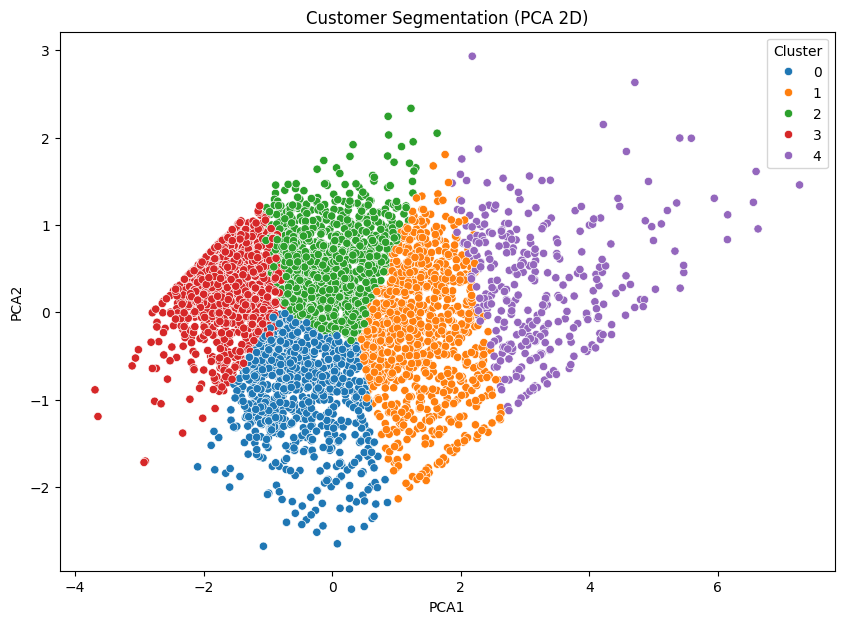

In [61]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(rfm_scaled)

rfm['PCA1'] = pca_coords[:,0]
rfm['PCA2'] = pca_coords[:,1]

plt.figure(figsize=(10,7))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title("Customer Segmentation (PCA 2D)")
plt.show()

# 📊 5 — Cluster Profiling

In [62]:
cluster_profile = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()

cluster_profile['Frequency']=np.round(cluster_profile['Frequency'],2)
cluster_profile['Monetary']=np.round(cluster_profile['Monetary'],2)
cluster_profile['Recency']=cluster_profile['Recency'].astype(int)

cluster_profile

,Recency,Frequency,Monetary
Cluster,,,
0,29,1.59,372.66
1,18,5.73,2088.18
2,104,3.10,1267.28
3,216,1.20,264.39
4,12,20.60,12642.19


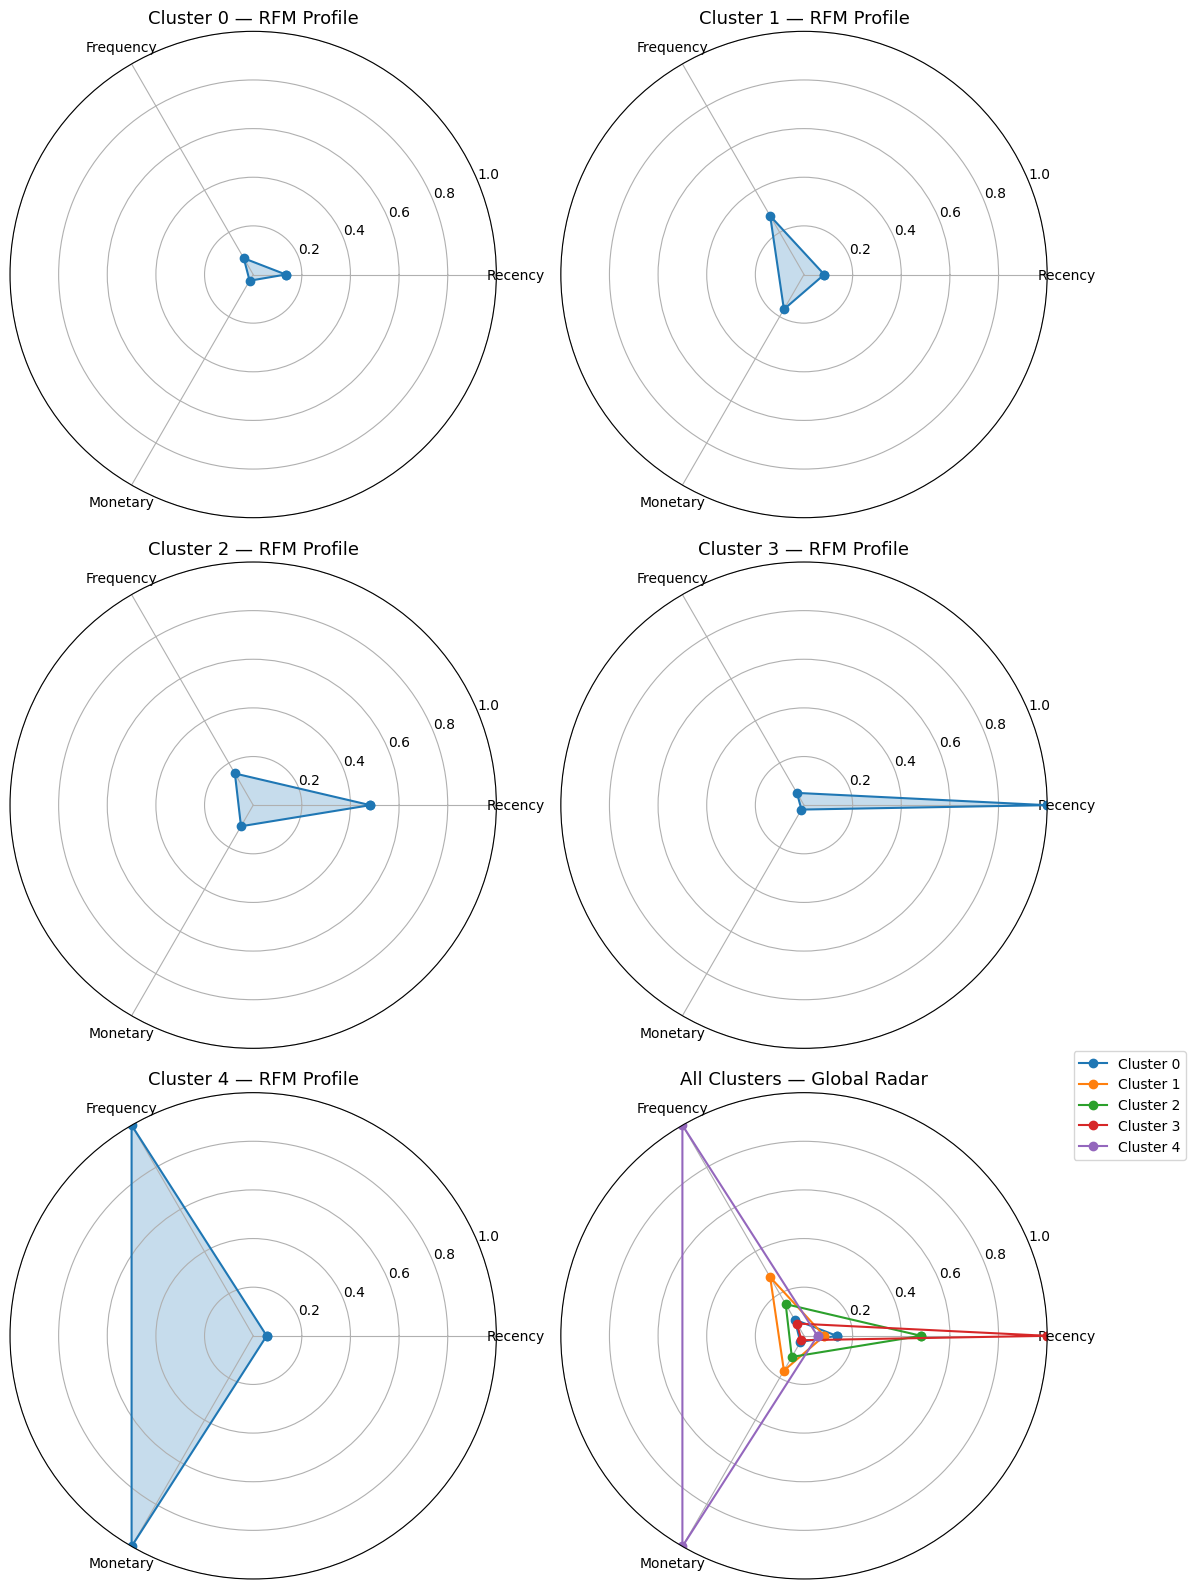

In [63]:
# Radar charts per cluster in a 3x2 subplot layout (normalized + fixed scale + global radar)

# Normalize values per variable (column-wise)
cluster_norm = cluster_profile / cluster_profile.max()

labels = ['Recency', 'Frequency', 'Monetary']
num_vars = len(labels)

# Angles for radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close loop

# Create subplot grid
fig, axes = plt.subplots(3, 2, figsize=(12, 16), subplot_kw=dict(polar=True))
axes = axes.flatten()

# --- 1) Individual radars ---
for idx, cluster_id in enumerate(cluster_norm.index):
    ax = axes[idx]

    values = cluster_norm.loc[cluster_id].tolist()
    values += values[:1]  # close loop

    ax.plot(angles, values, marker='o')
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)  # FIXED SCALE
    ax.set_title(f"Cluster {cluster_id} — RFM Profile", size=13)

# --- 2) Global radar in the 6th subplot ---
ax_global = axes[-1]

for cluster_id in cluster_norm.index:
    values = cluster_norm.loc[cluster_id].tolist()
    values += values[:1]
    ax_global.plot(angles, values, marker='o', label=f"Cluster {cluster_id}")

ax_global.set_xticks(angles[:-1])
ax_global.set_xticklabels(labels)
ax_global.set_ylim(0, 1)
ax_global.set_title("All Clusters — Global Radar", size=13)
ax_global.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


### Interpretation

The following section provides a business-oriented interpretation of each cluster based on their RFM averages.

Recency : How many days since the customer's last purchase.  
Frequency : How many distinct orders the customer made.  
Monetary : How much money the customer spent in total.

| Cluster | Label | Recency | Frequency | Monetary |
|--------|--------|---------|-----------|----------|
| 4 | VIP | Very recent | Very high | Extremely high |
| 1 | Loyal High-Value | Recent | High | High |
| 2 | Potential Loyalists | Not recent | Medium | Medium-high |
| 0 | Occasional Buyers | Recent | Low | Low |
| 3 | At-Risk | Very old | Very low | Very low |


- **Cluster 4 — VIP / Premium Customers**  
  They are the most valuable customers. They purchase very frequently, spend extremely large amounts, and have bought very recently
  * Ideal targets for VIP programs, exclusive offers and premium services.

- **Cluster 1 — Loyal High-Value Customers**  
  These customers buy regularly and generate strong revenue.  
  They are not as extreme as VIPs but remain highly profitable and engaged.
  * Good candidates for loyalty rewards, personalized recommendations, and retention campaigns.

- **Cluster 2 — Potential Loyalists**  
  These customers have spent a decent amount and purchased multiple times, but their last purchase was relatively long ago.
  * Perfect targets for reactivation campaigns, discount codes, and win-back strategies.

- **Cluster 0 — Occasional Buyers**  
  They buy infrequently and spend relatively little.  
  They are not disengaged but not loyal either.  
  * Good candidates for bundle offers, entry-level promotions.

- **Cluster 3 — At-Risk / Lost Customers**  
  These customers haven't purchased for a very long time and have low historical value.  
  They have most likely churned.
  * Only worth targeting with automated, low-cost reactivation campaigns.

# 💾 6 — Export results

In [64]:
rfm[['CustomerID','Recency','Frequency','Monetary','Cluster']].to_csv("rfm.csv", index=False)
rfm.to_csv("data_clustered.csv", index=False)

# 🧩 7 — Conclusion

### Key Insights
- RFM features reveal strong behavioral differences between customers  
- Clustering identifies distinct customer groups  
- PCA visualization confirms separation between segments  
- These clusters can be used for targeted marketing, retention, and personalization  

### Next Steps
- Build dashboards for each cluster  
- Create marketing personas  
- Combine RFM with product preferences (optional)

This segmentation provides a strong foundation for targeted marketing, customer retention, and lifetime value optimization.